# Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [9]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from collections import defaultdict

from utils import tools, preprocessing, models, eval, plotting, hpo

In [2]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 1.4.2
Numpy version: 1.26.4
Tensorflow version: 2.19.0


In [3]:
config = tools.load_config('config.yaml')
tools.initialize_gpu(7)

In [4]:
# paths
data = 'synth_pv'
key = 'pvpark_1.csv'

# model params
model_name = 'tcn-gru'
output_dim = 48 # in hours
epochs = 20
batch_size = 32
make_callbacks = False
strategy = 'fedavg'

# data params
freq = '1h'
lookback = 48 # in hours
horizon = 48 # in hours
# data split params
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False

# more params
evaluate_on_all_test_data = True
study_name = None#f'fl_a-{strategy}_d-{data}_m-{model_name}_out-{output_dim}_freq-{freq}'

In [5]:
# config related
config['data']['freq'] = freq
config['model']['name'] = model_name
config['model']['output_dim'] = output_dim
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon
config = tools.handle_freq(config=config)
freq = config['data']['freq']
output_dim = config['model']['output_dim']
config['model']['lookback'] = lookback
config['model']['horizon'] = horizon

In [6]:
# read data
#df = preprocessing.preprocess_1b_trina(path=path,
#                                       freq=freq)
known, observed, static = preprocessing.get_features(dataset_name=data)
rel_features = known + observed
dfs = preprocessing.get_data(dataset_name=data, data_dir='data', freq=freq, rel_features=rel_features)
#df = dfs[key]

In [7]:
test_start = None #pd.Timestamp(config['data']['test_start'])
prepared_data, df = preprocessing.pipeline(data=df,
                                           config=config,
                                           known_cols=known,
                                           observed_cols=observed,
                                           static_cols=static,
                                           test_start=test_start)
X_train, y_train = prepared_data['X_train'], prepared_data['y_train'],
X_test, y_test = prepared_data['X_test'], prepared_data['y_test']
index_train = prepared_data['index_train']
index_test = prepared_data['index_test']
scaler_y = prepared_data['scalers']['y']
#print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

NameError: name 'df' is not defined

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15696 entries, 2023-07-24 00:00:00+00:00 to 2025-05-07 23:00:00+00:00
Freq: H
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   global_horizontal_irradiance   15696 non-null  float64
 1   diffuse_horizontal_irradiance  15696 non-null  float64
 2   air_temperature                15696 non-null  float64
 3   wind_speed                     15696 non-null  float64
 4   direct_normal_irradiance       15696 non-null  float64
 5   power                          15696 non-null  float64
 6   power_lag_48                   15648 non-null  float64
dtypes: float64(7)
memory usage: 981.0 KB


In [12]:
config['model']['fl'] = False
study = hpo.load_study(config['hpo']['studies_path'], study_name)
hyperparameters = hpo.get_hyperparameters(config=config, study=study)
hyperparameters['epochs'] = epochs#config['model']['epochs']
hyperparameters['batch_size'] = batch_size#config['model']['epochs']

config['model']['name'] = model_name

config['model']['feature_dim'] = tools.get_feature_dim(X_train)
model = models.get_model(config=config,
                         hyperparameters=hyperparameters)

I0000 00:00:1752133365.154720  149018 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46735 MB memory:  -> device: 7, name: NVIDIA RTX A6000, pci bus id: 0000:e1:00.0, compute capability: 8.6


In [13]:
hyperparameters

{'shuffle': False,
 'batch_size': 32,
 'epochs': 20,
 'lr': 0.001,
 'filters': 64,
 'kernel_size': 3,
 'n_cnn_layers': 3,
 'increase_filters': False,
 'units': 64,
 'n_rnn_layers': 1}

In [14]:
#model.summary()

In [15]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test),
    shuffle = hyperparameters['shuffle']
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/20


I0000 00:00:1752133370.597951  149904 cuda_dnn.cc:529] Loaded cuDNN version 90800


366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0121 - mae: 0.0725 - rmse: 0.1072 - val_loss: 0.0088 - val_mae: 0.0566 - val_rmse: 0.0936
Epoch 2/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0045 - mae: 0.0425 - rmse: 0.0666 - val_loss: 0.0065 - val_mae: 0.0473 - val_rmse: 0.0805
Epoch 3/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0037 - mae: 0.0380 - rmse: 0.0607 - val_loss: 0.0057 - val_mae: 0.0446 - val_rmse: 0.0758
Epoch 4/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0034 - mae: 0.0359 - rmse: 0.0575 - val_loss: 0.0050 - val_mae: 0.0422 - val_rmse: 0.0704
Epoch 5/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0029 - mae: 0.0337 - rmse: 0.0529 - val_loss: 0.0036 - val_mae: 0.0367 - val_rmse: 0.0598
Epoch 6/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0022 - mae: 0.0297 - rmse: 0.0462 - val_loss: 0.0033 - val_mae: 0.0344 - val_rmse: 0.0577
Epoch 7/20
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0020 - mae: 0.0280 - rmse: 0.

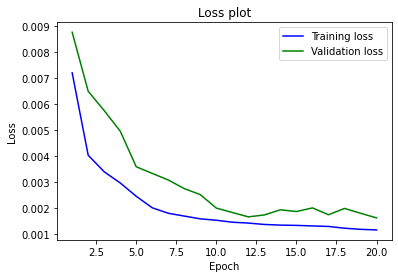

In [24]:
plotting.plot_training(history=history,
                       validation=True,
                       save_name=None)

In [25]:
y_true, y_pred = tools.get_y(X_test=X_test,
                             y_test=y_test,
                             scaler_y=scaler_y,
                             model=model)
df_pred = tools.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = tools.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

y_pers = eval.persistence(y=df['power'],
                    horizon=horizon,
                    from_date=str(index_test[0].date()))
y_pers = preprocessing.make_windows(data=y_pers,
                                    seq_len=y_pred.shape[-1])
df_pers = tools.y_to_df(y=y_pers,
                    output_dim=output_dim,
                    horizon=horizon,
                    index_test=index_test,
                    t_0=None if evaluate_on_all_test_data else t_0)

pers = {}
pers['Persistence'] = df_pers

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [26]:
results = eval.evaluate_models(pred=df_pred,
                               true=df_true,
                               persistence=pers,
                               main_model_name=model_name)

In [27]:
results

,R^2,RMSE,MAE,Skill
Models,,,,
tcn-gru,0.935690,0.039074,0.019933,0.615419
Persistence,0.565184,0.101602,0.042977,0.000000


R^2: 0.9349089716794252
RMSE: 0.0320779591245118
MAE: 0.015241884797308406


/home/viktorwalter/Work/forecasting_framework/utils/plotting.py:52: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  y_pred = pred.loc[time_index].values
/home/viktorwalter/Work/forecasting_framework/utils/plotting.py:53: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  y_true = true.loc[time_index].values


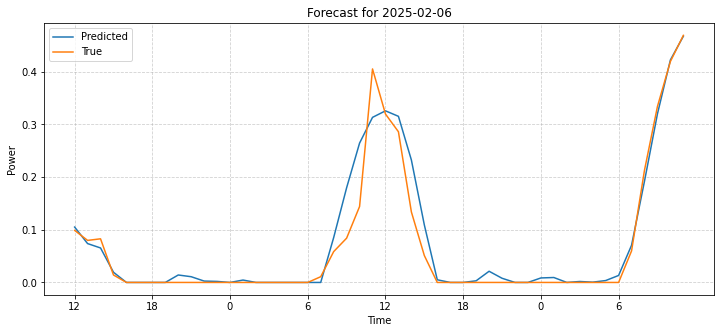

In [28]:
#date = '2018-06-06'
date = plotting.random_date(start_date=str(index_test[0].date()),
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

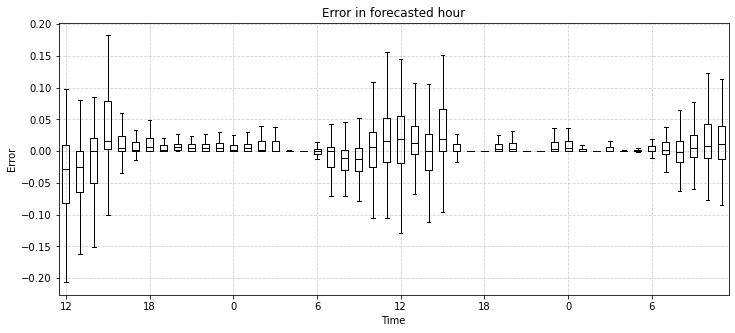

In [29]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

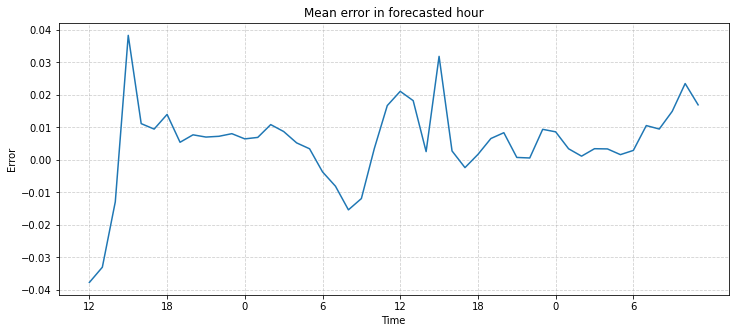

In [30]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

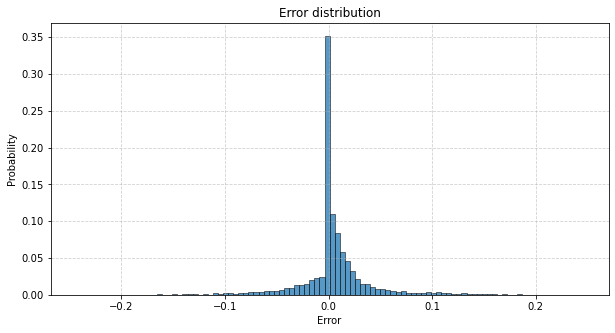

In [23]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)